In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CB2 Movie recommendation notebook

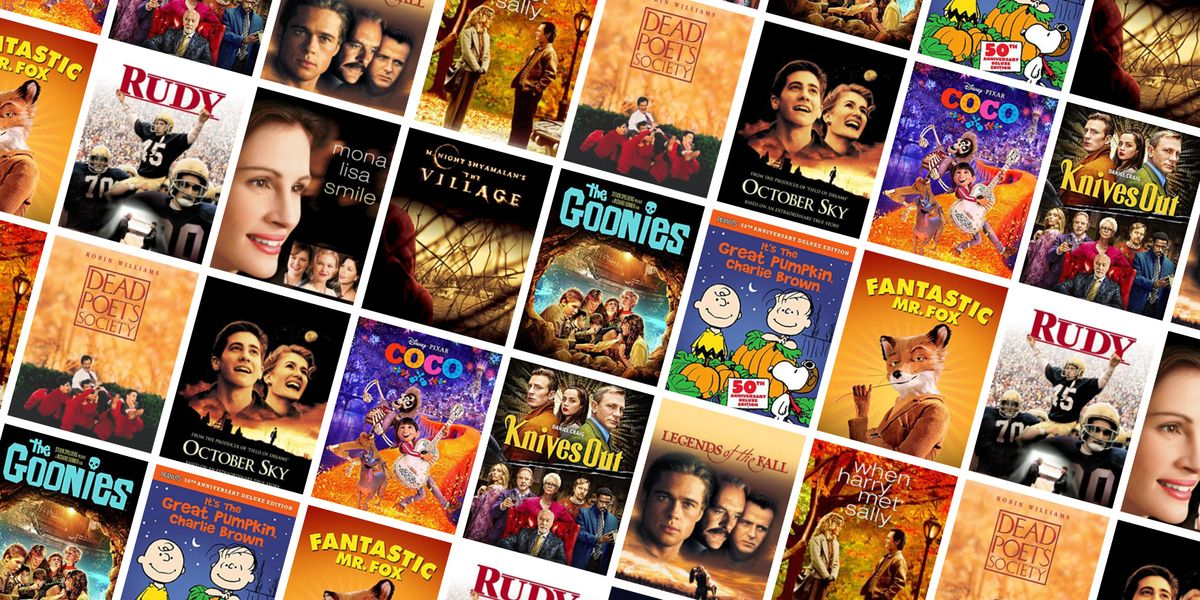

## Table of Contents

1. <a href ="#1.-Task-Description">Task Description</a>
2. <a href ="#2.-Evaluation">Evaluation</a>
3. <a href ="#3.-Comet-Experiment">Comet Experiment</a>
4. <a href ="#4.-Importing-Libraries">Importing Libraries</a>
5. <a href ="#5.-Importing-Data">Importing Data</a>
6. <a href ="#6.-Data-Overview">Data Overview</a>
7. <a href ="#7.-Exploratory-Data-Analysis"> Exploratory Data Analysis</a>
8. <a href ="#8.-Recommendation-System:-Content-Based-Filtering">Recommendation System: Content Based Filtering</a>
9. <a href ="#9.-Dimensionality-Reduction">Dimensionality Reduction</a>
10. <a href ="#10.-Collaborative-Filtering">Collaborative Filtering</a>
11. <a href ="#11.-Conclusion">Conclusion</a>
12. <a href ="#12.-Submission">Submission</a>

## 1. Task Description
In today’s technology driven world, recommender systems are socially and economically critical to ensure that individuals can make optimised choices surrounding the content they engage with on a daily basis. One application where this is especially true is movie recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, the client has tasked us to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

## 2. Evaluation


The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:
                                           

## 3. Comet

In [ ]:
!pip install comet_ml
# point comet_ml SDK to www.comet.com installation

# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="h3bQ9KYqt3r8nf4Y9oerJWCNn",
    project_name="cb2-movie-classifier",
    workspace="vicariousvision",
)

## 4. Importing Libraries

In [4]:
!pip install tensorflow-estimator==2.1.*
!pip install tensorflow==2.1
!pip install tensorflow==2.6

In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from sklearn.neighbors import  NearestNeighbors
import heapq
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import cufflinks as cf

# Packages for Randomisation
import random

#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud


## 5. Importing Data

In [4]:
#Movies dataframe
df_movies = pd.read_csv('movies.csv')

#sample submission
df_sample = pd.read_csv('sample_submission.csv')

#Genome_scores dataframe
df_gesc = pd.read_csv('genome_scores.csv')

#links dataframe
df_links = pd.read_csv('links.csv')

#Genome_tags dataframe
df_getg = pd.read_csv('genome_tags.csv')

#imbd dataframe
df_imdb = pd.read_csv('imdb_data.csv')

#tags dataframe
df_tags = pd.read_csv('tags.csv')

#train dataframe
df_train = pd.read_csv('train.csv')

#test dataframe 
df_test = pd.read_csv('test.csv')

## 6. Data Overview

We have been given 8 data files to work with an one sample file of what we should output. In these files are records of movie names, name of directors, cast, budget etc. 

In the data there are two rating sources that have been used, one from imDB and The Movie Database. We will try to use these rating scores in our model building.


In [38]:
df_movies.head(2) #contains movieId, title and genre

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [39]:
df_links.head(2) #provides a mapping between a MovieLens ID and associated IMDB and TMDB IDs.

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [40]:
df_tags.head(2) #User assigned for the movies within the dataset. Can be used to group simmilar users or movies

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256


In [41]:
df_imdb.head(2) #data from the imDB. Contains movieID, cast, director, runtime, budget and key words that are associated with its plot

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [42]:
df_train.head(2) #the data we will be training the model on. Time stamp could be dropped from this data.

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [43]:
df_train.info() #we're working with int data types which works for the models we are using

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [44]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


## 7. EDA

In [45]:
df_train["userId"].nunique() #The amount of users in the database

162541

In [46]:
df_train.movieId.nunique() #the number of movies in the database

48213

Lets take a look at the average rating of users and the average amount of movies watched by users. Firstly we will create a new dataframe with a users average rating and the number of movies and the number of times they have rated movies

In [47]:
#Dataframe consisting of the users average rating and number of times they have rated movies
df1 = pd.DataFrame(df_train.groupby('userId')['rating'].agg('mean').reset_index())
df2 = pd.DataFrame(df_train.groupby('userId')['rating'].count().reset_index())
# Merge the above to dataframe 
df1 = df1.merge(df2,on='userId',how = 'left')
# Rename the columns respectively
df1.rename(columns={'rating_x':'avg_rating','rating_y':'number_of_movies'},inplace = True)

# Sort the data in descending 
df1 = df1.sort_values('number_of_movies', ascending = False)

# Show 5 observations 
df1.head()

,userId,avg_rating,number_of_movies
72314,72315,3.092380,12952
80973,80974,3.277582,3680
137292,137293,3.192168,3588
33843,33844,2.583853,3208
20054,20055,3.179016,3050


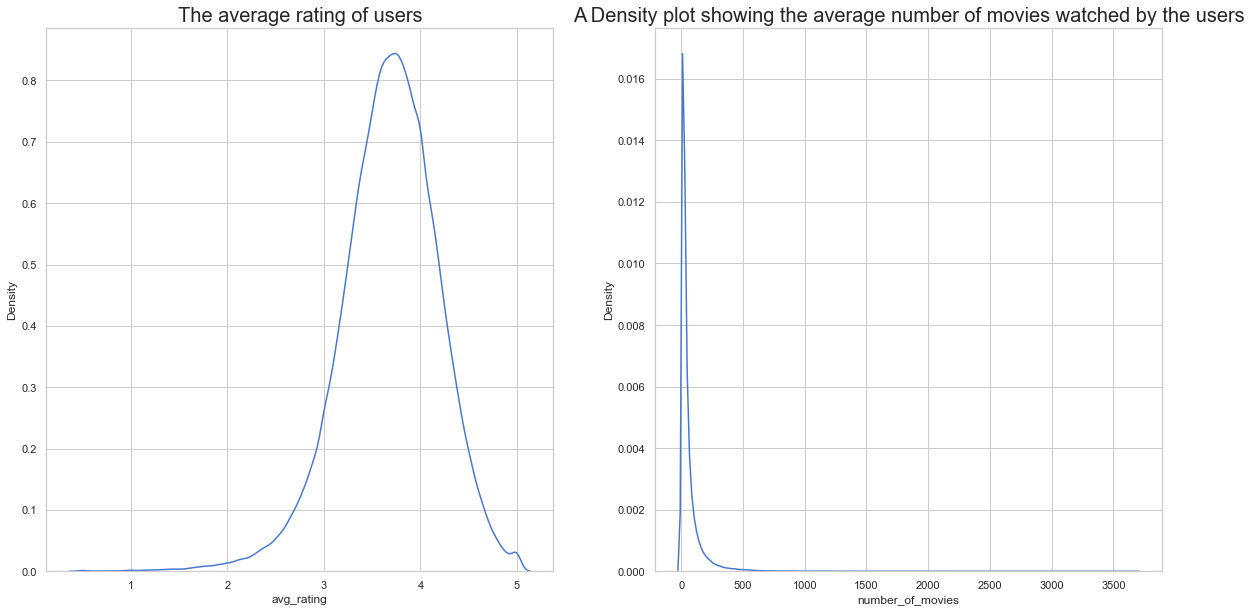

In [48]:
#Create a plot with set figure size
fig, ax = plt.subplots(1,2,figsize=(20, 10)) 

#Create a densityplot 
sns.kdeplot(ax=ax[0], x='avg_rating', data=df1) 
ax[0].set_title("The average rating of users",fontsize = 20)

# Set the axis labels to appear in standard form
plt.ticklabel_format(style='plain', axis='y', useOffset=False) 

# Create a KDE* plot of the rating the users 
sns.kdeplot(ax=ax[1], x='number_of_movies', data=df1[1:]) 
ax[1].set_title("A Density plot showing the average number of movies watched by the users",fontsize = 20)
    
# Show density plot
plt.show()

So most of the users ratings fall toward the positive side of the rating scale. This could mean that users are lenient or the movies that they have seen are just that good. 
*A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions. 

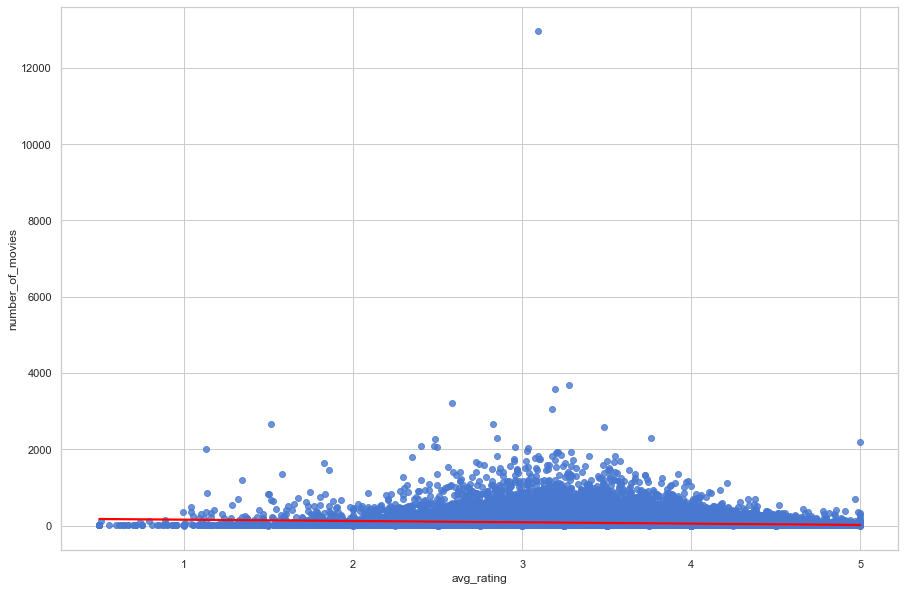

In [49]:
# Check for correlation between average rating and the number of the times have the user has watch a movie

# Create a scatter plot to visualise 
sns.regplot(data = df1, y = "number_of_movies", x = "avg_rating",line_kws={"color": "red"})

# Show the scatterplot
plt.show()

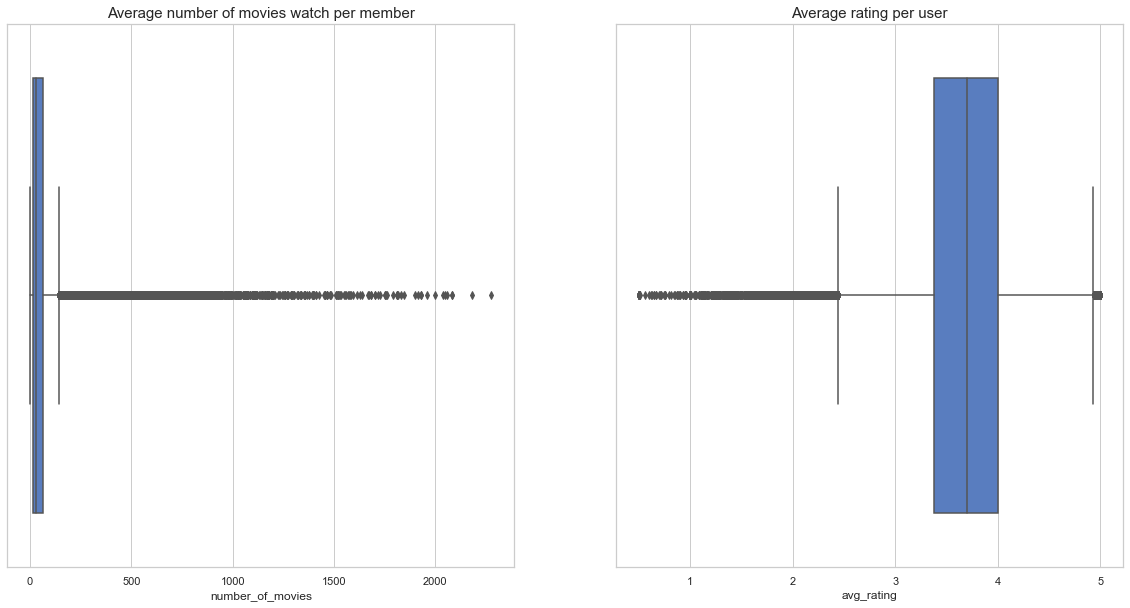

In [50]:
fig,ax = plt.subplots(1,2,figsize = (20,10))


sns.boxplot(ax =ax[0],x = df1.iloc[10:,2])

ax[0].set_title("Average number of movies watch per member", fontsize = 15)
sns.boxplot(ax = ax[1],x = df1.iloc[10:,1] )

ax[1].set_title("Average rating per user", fontsize = 15)
plt.show()

Looking at this box plot we can see that most users have seen less than 1000 movies, there are many users however who are outliers and have seen thousands of movies. Once again we see that the average rating is high.

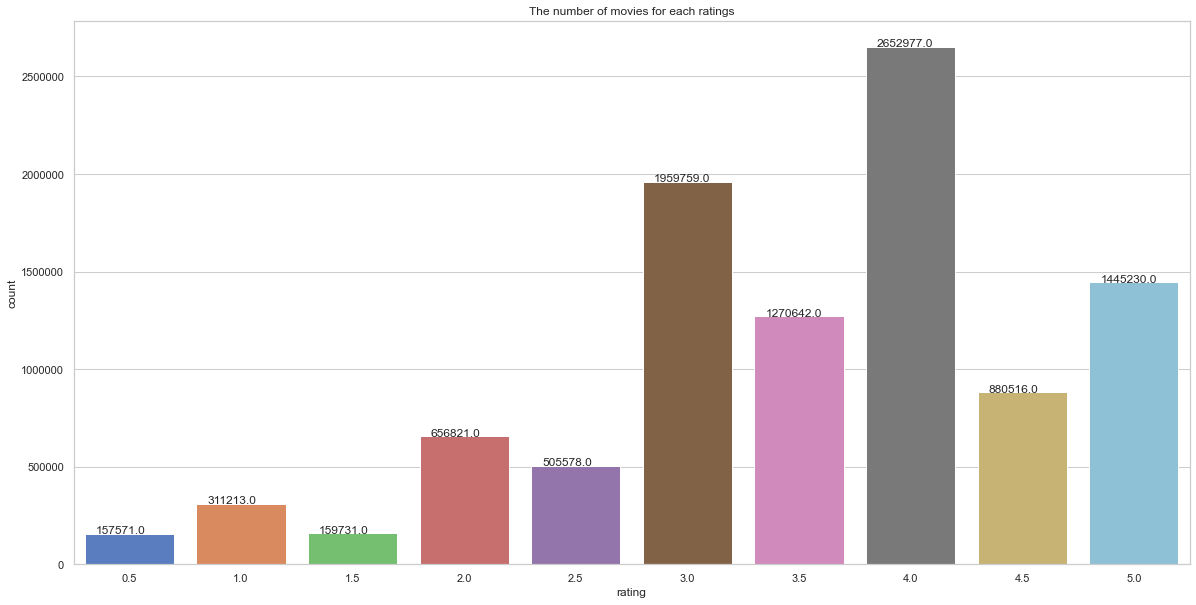

In [51]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(20, 10)) # Initialize the plot with set figure size

sns.countplot(ax=ax, x='rating', data=df_train) # Create a countplot to visualise the number of movies per category
ax.set_title("The number of movies for each ratings")
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Set the  labels to appear in non-scientific form

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
    
# Show the countplot
plt.show()

From the countplot, 60579966 movies in the dataset where rated 3.0 or above where most were rated given the rating of 4.0. Most of the movies in the data were very good considering the amount of movies that were rated 4.0 or above. With further scrutiny of the data, the observations acquired from the above chart will be explained in the next incoming sections.

From this bar chart we can see the actual number of movies that were rated in a certain rating class. We note that most movies are rated with a 4.


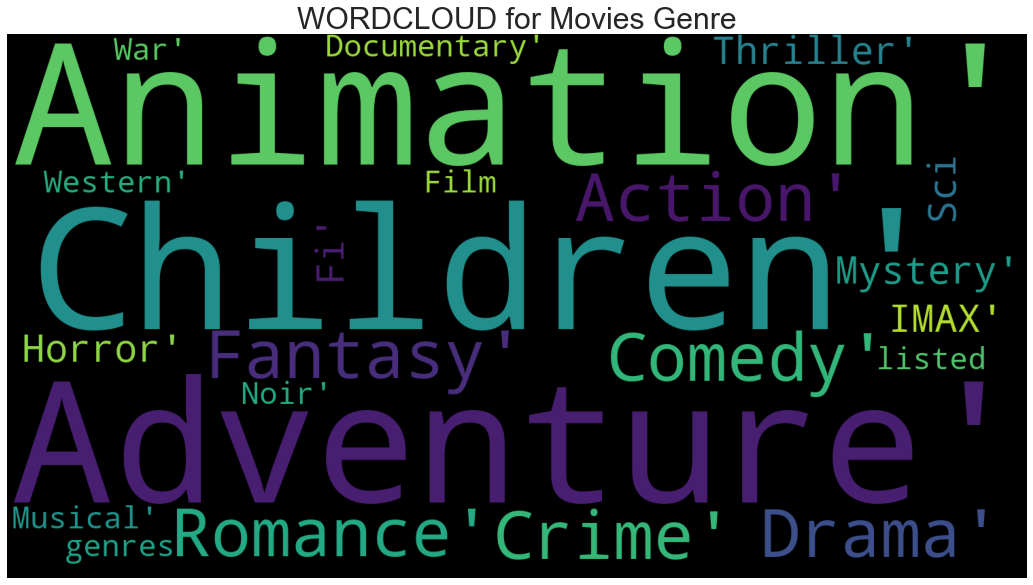

In [52]:
genres=[]
for genre in df_movies.genres:
    
    x=genre.split('|')
    for i in x:
         if i not in genres:
            genres.append(str(i))
genres=str(genres)    
movie_title=[]
for title in df_movies.title:
    movie_title.append(title[0:-7])
movie_title=str(movie_title)  

wordcloud_genre=WordCloud(width=1500,height=800,background_color='black',min_font_size=2
                    ,min_word_length=3).generate(genres)
wordcloud_title=WordCloud(width=1500,height=800,background_color='cyan',min_font_size=2
                    ,min_word_length=3).generate(movie_title)



plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre',fontsize=30)
plt.imshow(wordcloud_genre)



From the word cloud we can see that the most occuring genres that could be linked to family movies which would make sense since they are often easy to market and could be seen as a steady stream of income for movie studios so they would be more inclined to make more of them

Lets look at the distribution of tags in the user defined tags dataset

In [56]:
tag_count = pd.DataFrame(df_tags['tag'].
                           value_counts()).reset_index()
tag_count.rename(columns = {'index': 'genre', 'tag': 'count'},
                   inplace = True)
tag_count

,genre,count
0,sci-fi,8330
1,atmospheric,6516
2,action,5907
3,comedy,5702
4,surreal,5326
...,...,...
73045,teen sleuth,1
73046,evil twins,1
73047,paternity test,1
73048,QVC,1


<AxesSubplot:xlabel='genre', ylabel='count'>

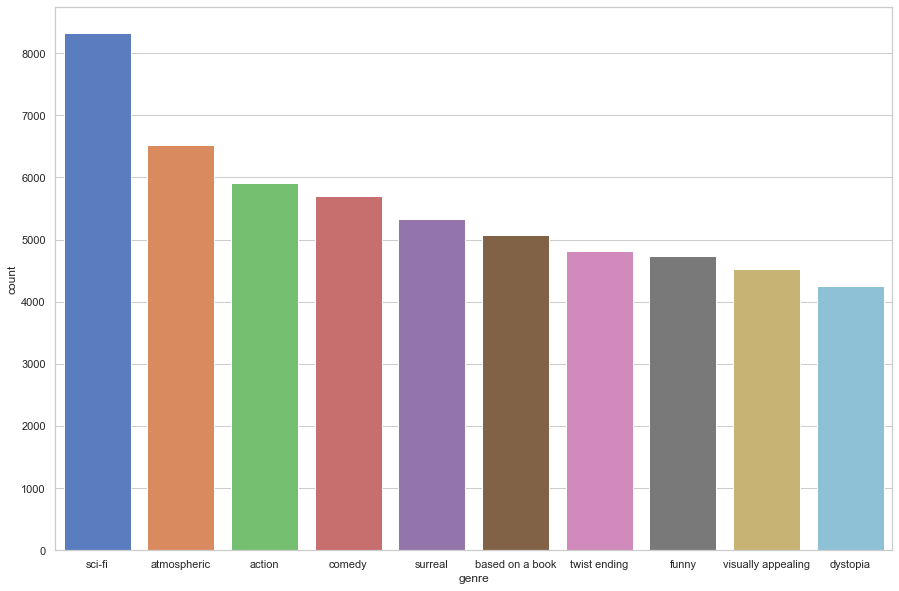

In [82]:
temp=tag_count[:10]
sns.barplot(x='genre',y='count',data=temp)

Here we see 'sci-fi' being the most tagged movie genre by users

Lets take a look at the 10 movies by rating in the dataset

In [20]:
df_top10=pd.merge(df_train,df_movies, how='left',on='movieId')


df1=df_top10.groupby(['title'])[['rating']].sum()
high_rated=df1.nlargest(10,'rating')
high_rated.head()

,rating
title,
"Shawshank Redemption, The (1994)",145035.0
Pulp Fiction (1994),132972.0
Forrest Gump (1994),131061.0
"Silence of the Lambs, The (1991)",122021.0
"Matrix, The (1999)",120531.5


(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

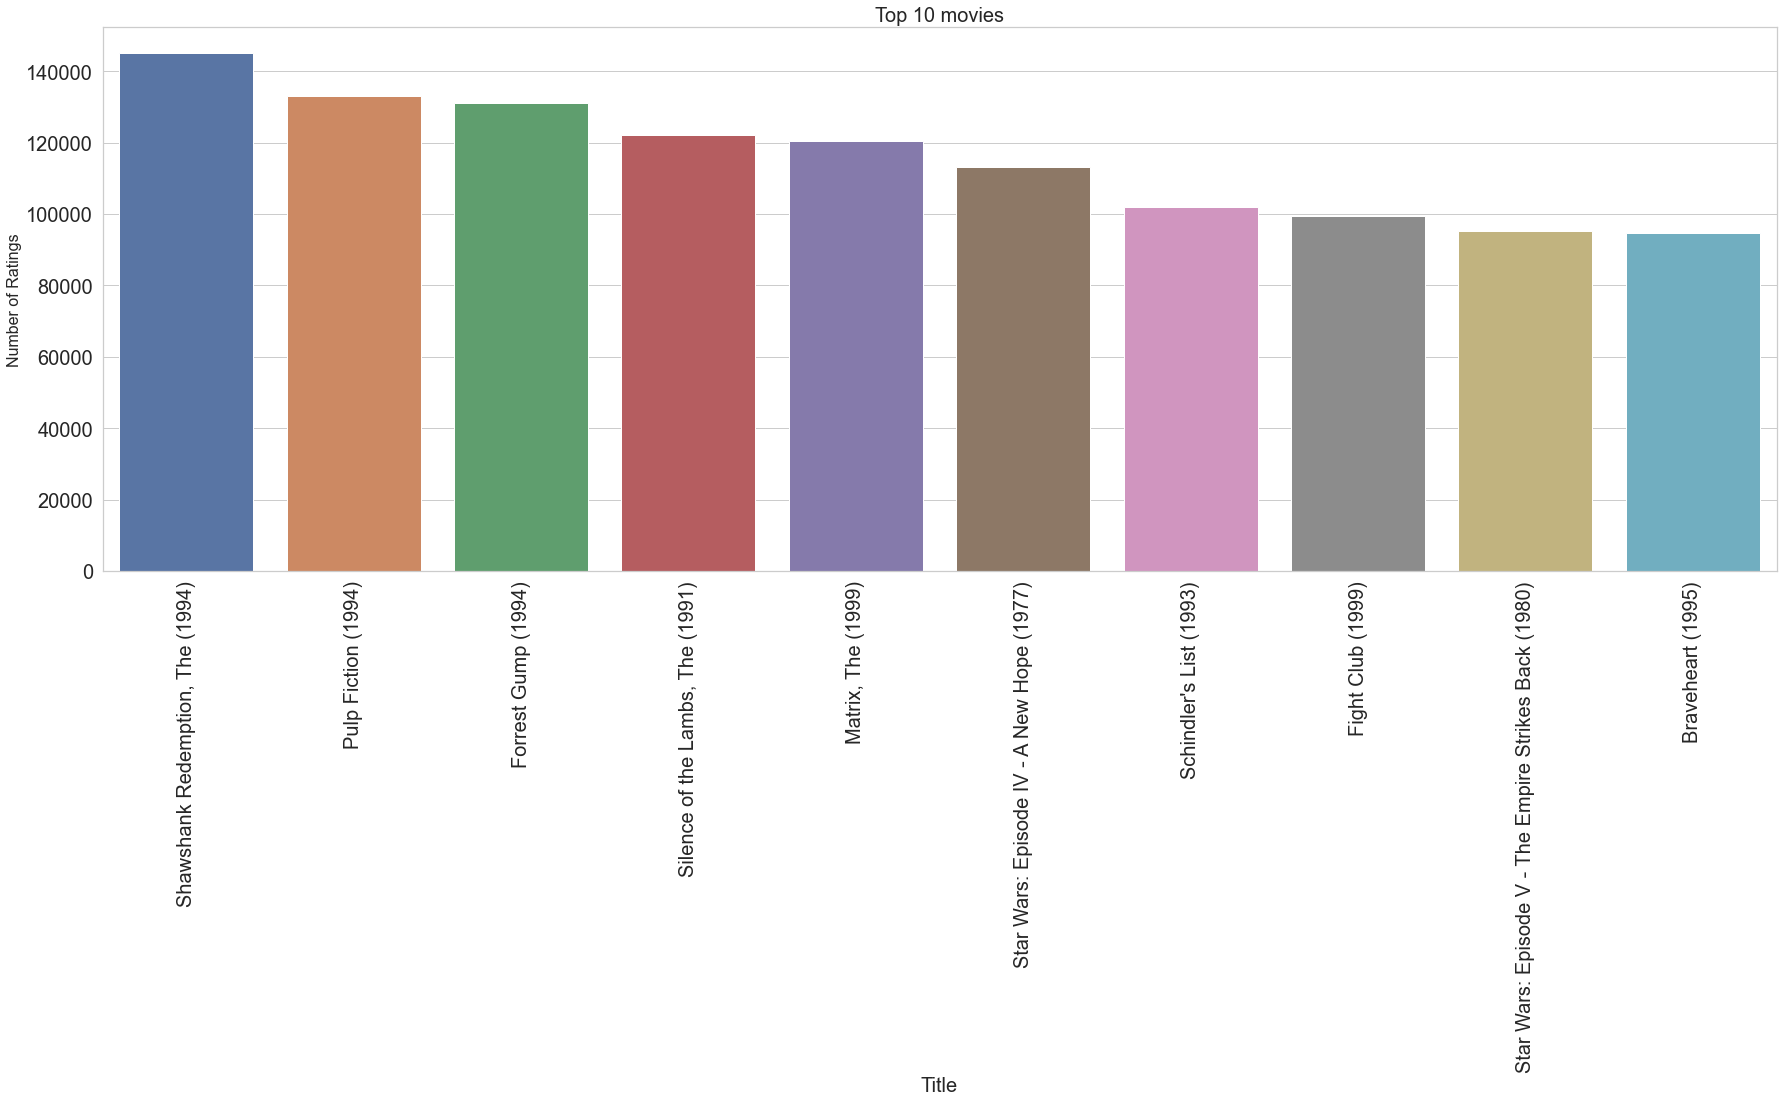

In [22]:
sns.set_theme(style="whitegrid")
ax=sns.barplot(x=high_rated.index, y=high_rated['rating'], data=high_rated)
ax.figure.set_size_inches(30,10)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('Title', fontsize=20);
plt.xticks(fontsize=20,rotation=90)

plt.ylabel('Number of Ratings', fontsize=16);
plt.title('Top 10 movies', fontsize=20)
plt.yticks(fontsize=20)



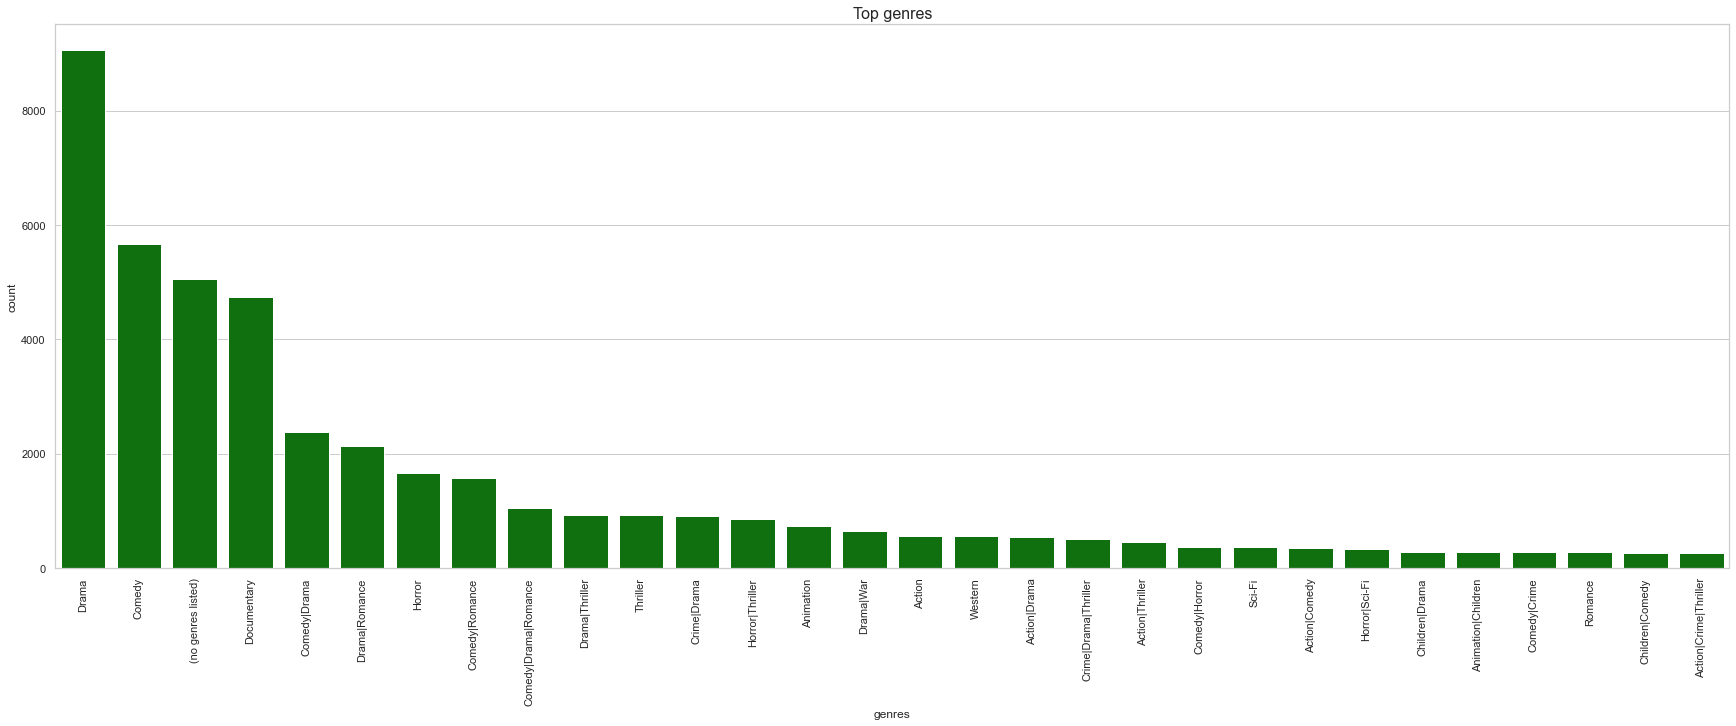

In [23]:
# Ploting top genres in the movies dataset
plt.figure(figsize=(30, 10))
gen = df_movies['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color='green')
ax.set_title('Top genres', fontsize=16)
plt.xticks(rotation =90)
plt.style.use('seaborn-whitegrid')
plt.show()

Drama and Comedy are the most popular genres, followed by Thriller and Romance. We need to keep in mind that the movies could have multiple genres.

## Building a model

We will try two approaches. Collaborative and content filtering. The first method is based on user ratings, the second is based on the items themselves. 

Firstly we try a content based approach. We will use a portion of the data as the dataset is substantial and using it in its entierty would be computationaly expensive. Content-based filtering makes recommendations by using keywords and attributes assigned to objects in a database (e.g., items in an online marketplace) and matching them to a user profile creating some form of feature matrix. The user profile is created based on data derived from a user’s actions, such as purchases, ratings (likes and dislikes), downloads, items searched for on a website and/or placed in a cart, and clicks on product links. An example of a feature matrix:

![Matrix](https://developers.google.com/machine-learning/recommendation/images/Matrix1.svg)

This method relies heavily on the similarities between features and relies on the feature matrix to compute the similarities between each features. The similarities are obtained by finding the distance using the cosine distance metric.

Cosine distance metric is calculated using the dot product 2 vectors over their norms. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1. cosine

![image](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2015/04/cosine.png?w=697&ssl=1)

In [15]:
df_movies.iloc[:3121,:] #we split the dataframe to make it easier to compute

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3116,3209,"Loves of Carmen, The (1948)",Drama
3117,3210,Fast Times at Ridgemont High (1982),Comedy|Drama|Romance
3118,3211,"Cry in the Dark, A (1988)",Drama
3119,3212,Born to Win (1971),Drama


Now having taking a sample of the data from the database we will perform some cleaning on the column of interest, the genre column. We look at this beacuse we would like to make recommendatons based on the simmilarity of genres as users can often times have narrow taste profiles when it comes to movies. For example women, enjoy Romantic movies more than men and they would enjoy less than men would whereas men would enjoy Horror more than women on average. 


Source: https://www.statista.com/statistics/254115/favorite-movie-genres-in-the-us/

#### Most popular movie genres among adults in the United States as of December 2018, by gender:

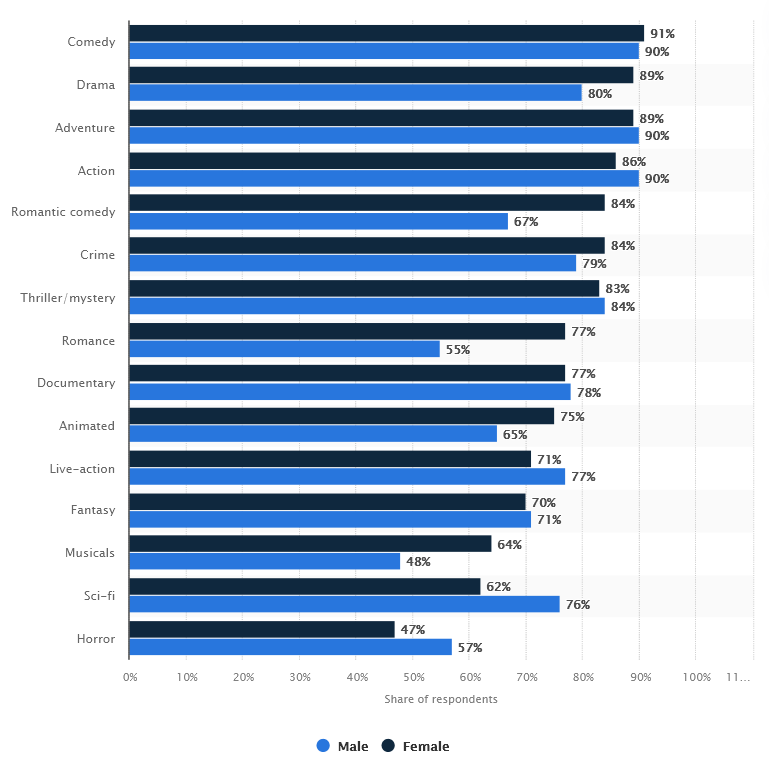

In [18]:
df_half = df_movies.iloc[:31210,:]
df_half['genres']=df_half['genres'].str.replace("|"," ") #remove the | delimter

In [6]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_half['genres'])  #creates a sparse matrix based on the frequency of genre words

In [7]:
from sklearn.metrics.pairwise import cosine_similarity #imports the cosine similarity libray 
cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix) #creates a matrix based on the similarity of the features

cosine_sim[0] #taking a look to see if we have correct outputs

array([1.        , 0.31652491, 0.06335082, ..., 0.        , 0.        ,
       0.        ])

In [9]:
df_half = df_half.reset_index()
titles = df_half['title']
indices = pd.Series(df_half.index, index=df_half['title'])

In [10]:
def movie_recommendations(title):
    """ 
        This function recommends movies based on the genres associated with an input movie title
        
        Inputs:
        'movie_title (year)'
        
        Returns:
        List of movies simmilar to input movie based on its similarity score
    
    """
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [13]:
movie_recommendations('Toy Story (1995)').head()

2203                                       Antz (1998)
3021                                Toy Story 2 (1999)
3653    Adventures of Rocky and Bullwinkle, The (2000)
3912                  Emperor's New Groove, The (2000)
4780                             Monsters, Inc. (2001)
Name: title, dtype: object

This model was based on the calculating the cosine simmilarity between genres associated with a movie and the simmilar movies that have simmilar scores. Often users browsing a site for movies would navigate to specific categories like drama, action or comedy and would find movies that have those as a main category with other genres acting as sub-categories. For example the movie Deadpool(2016) is an action movie but can also be said to be a comedy movie. 

While this model works for some movies, running the function on Toy Story as above returns simmilar animated childrens movies and the Toy Story sequel but for more complex queries it is somewhat innacurate. For example entering Batman: Mask of the Phantasm (1993) doesn't return a list of all the other Batman movies, as we would expect it to, it returns movies that are also kids movies but something a fan of Batman would rather not watch like Charlotte's Web. The likely reason for this is that this cosine method is computationally expensive so we had to use a portion of the data to build the model.

In [16]:
movie_recommendations('Batman: Mask of the Phantasm (1993)').head()

309     Swan Princess, The (1994)
608        Aristocats, The (1970)
2047       Charlotte's Web (1973)
2468       King and I, The (1999)
2475      Doug's 1st Movie (1999)
Name: title, dtype: object

In [39]:
movie_recommendations('The Jungle Book (2016)').head()

9081                 Sophie's World (Sofies verden) (1999)
10285    Valerie and Her Week of Wonders (Valerie a týd...
10787                    Nibelungen: Siegfried, Die (1924)
10788    Nibelungen: Kriemhild's Revenge, Die (Die Nibe...
12334                                     Fall, The (2006)
Name: title, dtype: object

In [89]:
def replace_name(x):
    return df_movies[df_movies['movieId']==x].title.values[0]
df_train.movieId = df_train.movieId.map(replace_name)

IndexError: index 1 is out of bounds for axis 0 with size 0

In [67]:
#df_train=df_train.drop(['timestamp'],axis=1)
df_train['userId'] = df_train['userId'].astype(str)
df_train['movieId'] = df_train['movieId'].astype(str)

In [84]:
df_train_half = df_train.iloc[:31210,:]

In [86]:
H=df_train_half.pivot_table(index='userId',columns='movieId',values='rating')

In [93]:
H

movieId,1,10,100,100044,100046,100163,100203,100244,1003,100383,...,99437,99470,996,99644,99695,99728,99764,998,999,99910
userId,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
def pearson(s1,s2):
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c*s2_c)/np.sqrt(np.sum(s1_c**2)*np.sum(s2_c**2))
    

In [94]:
pearson(H['100044'],H['100203'])

nan

In [40]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content Kfiltering algorithm.

    Imputs:
    subset_size : int
        Number of movies to use within the algorithm.

    Returns:
    Dataframe
        Subset of movies selected for content-based filtering.

    """
    movies = df_movies.copy()
    # Split the genres feature so that each genres will be in a list format 
    movies['genres'] = movies.genres.str.split('|')

    #Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
    moviesWithGenres_df = movies.copy()

    #For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
    for index, row in movies.iterrows():
        for genre in row['genres']:
            moviesWithGenres_df.at[index, genre] = 1
    #Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
    moviesWithGenres_df = moviesWithGenres_df.fillna(0)
    moviesWithGenres_df.drop(['genres'],axis =1, inplace = True)
    # Slice the data
    movie_subset = moviesWithGenres_df[:subset_size]

    return movie_subset

In [53]:
def content_model(movie_list,top_n=10):
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    recommended_movies = []
    # Preprocess the data 
    data = data_preprocessing(27000)

    # Create a new DataFrame
    data2 = data.copy()

    # Change the index of the DataFrame
    data2 = data2.set_index('title')

    # Delete the columns the unneccesary columns 
    data.drop(['title'],axis = 1,inplace=True)
    
    # Generating the count matrix for each genres
    data = data.set_index('movieId')

    # Instantiating the model and fitting the model to the count matrix
    nn = NearestNeighbors(algorithm='brute',metric='cosine',n_neighbors=10)
    nn.fit(data)

    # Create an Empty list for the movieids
    movieids = []

    # Getting the movieids
    ind1 = data2.loc[movie_list[0],'movieId']


    # Adding the movieids to the list
    movieids.extend([ind1])
    # Setting a list of indexes
    index_list = []

    # Getting the suggestions in form of indexes
    for i in range(len(movieids)):
        distances,suggestions=nn.kneighbors(data.loc[movieids[i],:].values.reshape(1,-1),n_neighbors=15)

        for j in range(15):
            index_list.append(suggestions[0,j])

    # Creating an empty list to store the movie ids 
    movieids2 = []
    
    # Create a for loop get the titles of the movies
    for i in range(len(index_list)):
        id = data.index.values[index_list[i]]
        movieids2.append(id)

    # Create a list to store all the titles
    title_list = []

    # Create a new dataframe to get the titles of the movies and change the index to movieId 
    data3 = data_preprocessing(10000000)
    data3 = data3.set_index('movieId')

    for i in range(len(movieids2)):
        title = data3.loc[movieids2[i],'title']
        if(title not in movie_list):
            title_list.append(title)

    # recommended movies 
    recommended_movies.extend(random.sample(title_list,k = top_n))
    return recommended_movies

In [55]:

movielist = ["Batman: Mask of the Phantasm (1993)"]

# Run the recommendation
recommendation = content_model(movielist,1)

print(recommendation)

['Pelle Svanslös (1981)']


# Content based filtering

In [124]:


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

dbutils.library.installPyPI("mlflow")
dbutils.library.restartPython()
import mlflow



NameError: name 'dbutils' is not defined

In [125]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [126]:


from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()



In [127]:


movies_df = spark.read.load("movies.csv", format='csv', header = True)
ratings_df = spark.read.load("train.csv", format='csv', header = True)
links_df = spark.read.load("links.csv", format='csv', header = True)
tags_df = spark.read.load("tags.csv", format='csv', header = True)



In [156]:
ratings_df.join(movies_df,'movieId').show(2)

+-------+------+------+----------+--------------------+--------------------+
|movieId|userId|rating| timestamp|               title|              genres|
+-------+------+------+----------+--------------------+--------------------+
|  57669|  5163|   4.0|1518349992|    In Bruges (2008)|Comedy|Crime|Dram...|
|      5|106343|   4.5|1206238739|Father of the Bri...|              Comedy|
+-------+------+------+----------+--------------------+--------------------+
only showing top 2 rows



In [188]:
data = ratings_df.select('userId','movieId','rating')

split = data.randomSplit([0.7,0.3])
train = split[0].withColumnRenamed('rating','label')
test = split[1].withColumnRenamed('rating','trueLable')

train_rows = train.count()
test_rows = test.count()



In [187]:
from pyspark.sql.types import IntegerType, FloatType
ratings_df = ratings_df.withColumn("userId", ratings_df["userId"].cast(IntegerType()))
data = data.withColumn("userId", data["userId"].cast(IntegerType()))

In [189]:
from pyspark.ml.recommendation import ALS

als = ALS(maxIter=19, regParam=0.01, userCol='userId',itemCol="movieId",ratingCol='label',coldStartStrategy = "drop")
model = als.fit(train)

In [190]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

IllegalArgumentException: rating does not exist. Available: userId, movieId, trueLable, prediction

In [194]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row


ratings = spark.read.load("train.csv", format='csv', header = True)





# Data type convert
from pyspark.sql.types import IntegerType, FloatType
ratings = ratings.withColumn("userId", ratings["userId"].cast(IntegerType()))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast(IntegerType()))
ratings = ratings.withColumn("rating", ratings["rating"].cast(FloatType()))




(training, test) = ratings.randomSplit([0.8, 0.2])


# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

Root-mean-square error = 0.8822162949417659


In [ ]:
predict_df = model.<FILL_IN>

# Remove NaN values from prediction (due to SPARK-14489)
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))

In [128]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

In [129]:
movie_ratings=ratings_df.drop('timestamp')

In [130]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [131]:


# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))



In [132]:
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [133]:


# Create ALS model
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")



In [134]:
paramGrid = (ParamGridBuilder()
             .addGrid(als.regParam, [0.01])
             .addGrid(als.rank, [10])
             .addGrid(als.maxIter, [15])
             .build())

In [135]:


# Define evaluator as RMSE

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")



In [136]:
ratings_df

DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

In [137]:
from pyspark.ml.tuning import CrossValidator
# Build Cross validation 
# Create 5-fold CrossValidator
# it takes too long that I only use 2-fold
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
cvModel = cv.fit(training)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [180]:
best_model = cvModel.bestModel

In [140]:


#Fit ALS model to training data

# specify parameter settings by the best model obtained via CV
print ("**Best Model**")
print ("Rank: ", best_model)
print (" MaxIter: ", str(best_model._java_obj.parent().getMaxIter()))
print (" RegParam:",  best_model._java_obj.parent().regParam())



**Best Model**
Rank:  ALSModel: uid=ALS_57bea5ae8d5a, rank=10
 MaxIter:  15
 RegParam: ALS_57bea5ae8d5a__regParam


In [141]:
predictions=best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [142]:
print ("RMSE = "+str(rmse))

RMSE = 0.881337687181007


In [143]:
als_best = ALS(maxIter=15, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als_best.fit(training)

In [145]:
predictions.show(10)

predictions.createOrReplaceTempView("predictions")

display (spark.sql("SELECT * FROM predictions limit 10"))

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   285|    471|   4.0| 2.6773593|
|   325|   1580|   3.0|  3.190968|
|   388|  44022|   4.0| 4.1220326|
|   435|   1645|   1.0|  3.457787|
|   513|  44022|   5.0|   4.48963|
|   548|   1580|   3.5| 3.7246847|
|   548|   1088|   4.0|  3.260343|
|   548|   1591|   2.5|  2.854127|
|   613|   1088|   4.0|  3.078021|
|   625|    471|   4.0|  4.753599|
+------+-------+------+----------+
only showing top 10 rows



DataFrame[userId: int, movieId: int, rating: float, prediction: float]

In [146]:
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.7088609741927319


In [151]:
alldata.registerTempTable("alldata")

In [154]:


#recommend 10 movies for each users
user_recs = best_model.recommendForAllUsers(10)
#user_recs.show(10)

user_recs.createOrReplaceTempView("user_recs")

display (spark.sql("SELECT * FROM user_recs limit 10"))



DataFrame[userId: int, recommendations: array<struct<movieId:int,rating:float>>]

In [155]:
user_recs.first()

Row(userId=1, recommendations=[Row(movieId=191251, rating=10.565855026245117), Row(movieId=205509, rating=10.412291526794434), Row(movieId=124131, rating=10.223634719848633), Row(movieId=160301, rating=9.986960411071777), Row(movieId=185905, rating=9.781705856323242), Row(movieId=167494, rating=9.660938262939453), Row(movieId=71141, rating=9.551904678344727), Row(movieId=8070, rating=9.093806266784668), Row(movieId=48501, rating=9.068181991577148), Row(movieId=135693, rating=9.030214309692383)])

In [106]:
scaler = StandardScaler()
scaled_df = preprocessing.scale(df_train)
scaled_df

array([[-1.62492551,  0.92560702,  0.43972695,  1.33399353],
       [ 0.53733674, -0.5455718 ,  0.91092541, -0.0416001 ],
       [ 1.40170738, -0.40642416,  1.38212386, -0.61466206],
       ...,
       [ 1.57303429,  0.90297703,  0.43972695,  0.05287685],
       [ 0.09843041, -0.53735663,  0.43972695,  1.16462461],
       [ 1.24499786, -0.51995679,  0.43972695, -1.57208072]])

In [107]:
# exclude non-features from data
reg_data = scaled_df

# set aside response variable (Unscaled!)
reg_response = df_train["rating"]

# drop response variable
reg_data = reg_data.drop(['rating'], 1)


AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reg_data, reg_response, test_size=0.2)

In [ ]:
# create PCA object with n_components set to 2
pca_reg = PCA(n_components=2)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

In [ ]:
pca_reg.explained_variance_ratio_.sum()

In [196]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

#our training data
df = pd.DataFrame(df_train)
#del df['timestamp']


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [199]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
grid_search = GridSearchCV(SVDpp, param_grid, scoring='fowlkes_mallows_score')

In [200]:
#packages we need
from surprise import accuracy
from surprise.model_selection import train_test_split

#allows us to train on the whole dataset
trainset = data.build_full_trainset()

#SVD algorithm.
algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset



## Conclusion
In this project we set out to build a machine learning model that would be able to recommend movies based to users. We attempted two approaches in doing this, firstly by basing the recommendation on the ratings and secondly on the movies themsleves. 

How this serves the business:

Recommendation engines have the possibility to make or break a business and we illustrate the importance of having something like it to meet the demands of customers. Many large companies have different systems that are always being updated with the latest methods to recommend customers the products they most likely to either purchase or watch. The value in this system lies in keeping customers on the streaming platform for longer doing so has multiple benefits to the companies financial interest. Firstly, having a system that is accurate (or close to perfect) at predicting customer tastes has the potential to keep customers coming back to the service time and time again. 

Submission

In [ ]:
#saving the predictions as a list to add as a column for our Kaggle submission
ratings = [i.est for i in predictions]
ratings

In [ ]:
df_test['Id'] = df_test['userId'].astype(str)  + '_'+ df_test['movieId'].astype(str) 

In [ ]:
df_test['rating'] = ratings
del df_test['userId']
del df_test['movieId']

In [ ]:
df_test

In [ ]:
df_test['R'] = df_test['rating']
del df_test['rating']

df_test['rating'] = df_test['R']

del df_test['R']


In [ ]:
df_test

In [ ]:
df_test.to_csv('Kaggle_submission.csv', index = False)